# Objective: Determine the optimal way to increase study size

- scPOST allows users to change their simulated study design so that they may test how different study design choices affect their power.
- One of the most common ways to increase power in a study is to increase the size. In scRNA-seq experiments, there a multiple ways to do this. One might imagine a trying to invest time in trying to obtain more samples in their study, or attempting to optimize their protocols to increase their cells per sample yield. 

Here, we'll simulate datasets from a rheumatoid arthritis (RA) dataset described in Zhang F, Wei K, Slowikowski K, Fonseka C, Rao DA, *et al.*, *Nature Immunol* (2020). The metadata and PC embeddings for this batch-corrected dataset is provided in the pre-loaded data: ra_HarmObj.

In this tutorial, we'll:
- Simulate datasets featuring study designs that contain a range of sample sizes and cells per sample.
- Visualize how power increases as we increase the study size.

**In this tutorial, we assume you have at least read the "Getting Started" tutorial, which provides more detail in creating scPOST workflows.**

## Load packages

In [1]:
suppressPackageStartupMessages({
    # imports for analyses
    library(scpost)
    library(dplyr)
    
    # imports for figures
    library(ggplot2)
    library(viridis)
    library(patchwork)
})

fig.size <- function (height, width) {
    options(repr.plot.height = height, repr.plot.width = width)
}

# Step 1: Parameter estimation

In [2]:
system.time({
    ra_freqEstimates <- estimateFreqVar(meta = ra_HarmObj$meta, clusCol = 'harmClus', sampleCol = 'sample', logCov = TRUE)
})

   user  system elapsed 
  0.320   0.004   0.398 

In [3]:
system.time({
    ra_pcEstimates <- estimatePCVar(pca = ra_HarmObj$embeddings, npcs = 20, meta = ra_HarmObj$meta, clusCol = 'harmClus',
                                    sampleCol = 'sample', batchCol = 'batch')
})

   user  system elapsed 
 10.914   0.017  11.167 

# Step 2 & 3: Simulate datasets

Here, we'll simulate a realistic dataset like we did in the "Getting Started" tutorial. However, we'll now vary how many cells per sample are simulated, or vary the sample size (in addition, we scale up the number of batches in the study with the number of samples). For simplicity, we only simulate 2 replicates forr each sample/cells per sample combination - in practice, we recommend simulating more replicates, which is often best done in parallel or by adapting this code into a script for an LSF. 

In this workflow: we created a folder for a particular sample size. We then simulated datasets where we we varied the number of cells per sample for a particular sample size and placed the data into the folder for that sample size. We then created folders for increased samples sizes and placed the relevant simulated datasets into the relevant sample size folder.

**Note: we perform a differential abundance test, MASC, so simulation and testing time will increase as the study size increases.** For simplicity, we only test a range of 50, 100 and 200 cells per sample (many studies will contain a larger cells per sample). 

## 20 samples

In [27]:
set.seed(23)

# Set the number of samples, number of cells per sample, and create batch structure
ncases <- 10
nctrls <- 10
nbatches <- 5
batchStructure <- distribSamples(ncases = ncases, nctrls = nctrls, nbatches = nbatches)

# set range of cells per sample
ncells_range <- c(50,100,200)
ncells <- lapply(seq(ncells_range), function(x){
    a <- rep(ncells_range[x], times = ncases + nctrls)
    names(a) <- batchStructure$sample_names
    return(a)
})

params <- expand.grid(
    rep = seq(5), 
    ncases = ncases, 
    nctrls = nctrls, 
    nbatches = nbatches, 
    b_scale = 1, 
    s_scale = 1, 
    cf_scale = 1, 
    clus = "clus0", 
    fc = 3, 
    res_use = 2, 
    ncells = ncells,
    save_path = file.path(getwd(), "scpostSims/cellsVsSamples/20samples/")
)
params$cond_induce = "cases"
params$seed <- sample(.Machine$integer.max, size = nrow(params))
params %>% dim
params %>% head(2)

[1] 15 14

,rep,ncases,nctrls,nbatches,b_scale,s_scale,cf_scale,clus,fc,res_use,ncells,save_path,cond_induce,seed
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<list>,<fct>,<chr>,<int>
1,1,10,10,5,1,1,1,clus0,3,2,"50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50",/data/srlab1/nmillard/scpost/vignettes/scpostSims/cellsVsSamples/20samples/,cases,265763406
2,2,10,10,5,1,1,1,clus0,3,2,"50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50",/data/srlab1/nmillard/scpost/vignettes/scpostSims/cellsVsSamples/20samples/,cases,1113800433


In [14]:
suppressWarnings({
    lapply(seq(nrow(params)), function(x){
            simDataset.withMASC(
                save_path = params[x, 'save_path'],
                rep = params[x, 'rep'],
                seed = params[x, 'seed'],
                ncases = params[x, 'ncases'],
                nctrls = params[x, 'nctrls'],
                nbatches = params[x, 'nbatches'],
                batchStructure = batchStructure,
                ncells = params[x, 'ncells'][[1]],
                centroids = ra_pcEstimates$centroids,
                pc_cov_list = ra_pcEstimates$pc_cov_list,
                batch_vars = ra_pcEstimates$batch_vars,
                b_scale = params[x, 'b_scale'],
                sample_vars = ra_pcEstimates$sample_vars,
                s_scale = params[x, 's_scale'],
                cfcov = ra_freqEstimates$cfcov,
                cf_scale = params[x, 'cf_scale'],
                meanFreqs = ra_freqEstimates$meanFreq,
                clus = params[x, 'clus'],
                fc = params[x, 'fc'],
                cond_induce = params[x, 'cond_induce'],
                res_use = params[x, 'res_use'], 
                mc.cores = 1,
                clusterData = TRUE,
                returnPCs = FALSE
            )
    })
})

Simulated dataset at 2021-07-21 13:21:01

Simulated dataset at 2021-07-21 13:21:03

Simulated dataset at 2021-07-21 13:21:05

Simulated dataset at 2021-07-21 13:21:06

Simulated dataset at 2021-07-21 13:21:08

Simulated dataset at 2021-07-21 13:21:12

Simulated dataset at 2021-07-21 13:21:15

Simulated dataset at 2021-07-21 13:21:18

Simulated dataset at 2021-07-21 13:21:21

Simulated dataset at 2021-07-21 13:21:24

Simulated dataset at 2021-07-21 13:21:29

Simulated dataset at 2021-07-21 13:21:34

Simulated dataset at 2021-07-21 13:21:39

Simulated dataset at 2021-07-21 13:21:45

Simulated dataset at 2021-07-21 13:21:50



[[1]]
NULL

[[2]]
NULL

[[3]]
NULL

[[4]]
NULL

[[5]]
NULL

[[6]]
NULL

[[7]]
NULL

[[8]]
NULL

[[9]]
NULL

[[10]]
NULL

[[11]]
NULL

[[12]]
NULL

[[13]]
NULL

[[14]]
NULL

[[15]]
NULL

## 40 samples

Again, we create a folder for the 40-sample simulations and place them into that folder. As dataset size increases, the time it takes to simulate and perform differential abundance tests will also increase (differential abundance test tends to comprise the larger portion of computation time).

In [6]:
set.seed(23)

# Set the number of samples, number of cells per sample, and create batch structure
ncases <- 20
nctrls <- 20
nbatches <- 10
batchStructure <- distribSamples(ncases = ncases, nctrls = nctrls, nbatches = nbatches)

# set range of cells per sample
ncells_range <- c(50,100,200)
ncells <- lapply(seq(ncells_range), function(x){
    a <- rep(ncells_range[x], times = ncases + nctrls)
    names(a) <- batchStructure$sample_names
    return(a)
})

params2 <- expand.grid(
    rep = seq(5), 
    ncases = ncases, 
    nctrls = nctrls, 
    nbatches = nbatches, 
    b_scale = 1, 
    s_scale = 1, 
    cf_scale = 1, 
    clus = "clus0", 
    fc = 3, 
    res_use = 2, 
    ncells = ncells,
    save_path = file.path(getwd(), "scpostSims/cellsVsSamples/40samples/")
)
params2$cond_induce = "cases"
params2$seed <- sample(.Machine$integer.max, size = nrow(params2))

In [7]:
suppressWarnings({
    lapply(seq(nrow(params2)), function(x){
            simDataset.withMASC(
                save_path = params2[x, 'save_path'],
                rep = params2[x, 'rep'],
                seed = params2[x, 'seed'],
                ncases = params2[x, 'ncases'],
                nctrls = params2[x, 'nctrls'],
                nbatches = params2[x, 'nbatches'],
                batchStructure = batchStructure,
                ncells = params2[x, 'ncells'][[1]],
                centroids = ra_pcEstimates$centroids,
                pc_cov_list = ra_pcEstimates$pc_cov_list,
                batch_vars = ra_pcEstimates$batch_vars,
                b_scale = params2[x, 'b_scale'],
                sample_vars = ra_pcEstimates$sample_vars,
                s_scale = params2[x, 's_scale'],
                cfcov = ra_freqEstimates$cfcov,
                cf_scale = params2[x, 'cf_scale'],
                meanFreqs = ra_freqEstimates$meanFreq,
                clus = params2[x, 'clus'],
                fc = params2[x, 'fc'],
                cond_induce = params2[x, 'cond_induce'],
                res_use = params2[x, 'res_use'], 
                mc.cores = 1,
                clusterData = TRUE,
                returnPCs = FALSE
            )
    })
})

Simulated dataset at 2021-07-21 13:15:52

Simulated dataset at 2021-07-21 13:15:55

Simulated dataset at 2021-07-21 13:15:58

Simulated dataset at 2021-07-21 13:16:01

Simulated dataset at 2021-07-21 13:16:04

Simulated dataset at 2021-07-21 13:16:10

Simulated dataset at 2021-07-21 13:16:15

Simulated dataset at 2021-07-21 13:16:20

Simulated dataset at 2021-07-21 13:16:25

Simulated dataset at 2021-07-21 13:16:31

Simulated dataset at 2021-07-21 13:16:40

Simulated dataset at 2021-07-21 13:16:50

Simulated dataset at 2021-07-21 13:17:00

Simulated dataset at 2021-07-21 13:17:10

Simulated dataset at 2021-07-21 13:17:19



[[1]]
NULL

[[2]]
NULL

[[3]]
NULL

[[4]]
NULL

[[5]]
NULL

[[6]]
NULL

[[7]]
NULL

[[8]]
NULL

[[9]]
NULL

[[10]]
NULL

[[11]]
NULL

[[12]]
NULL

[[13]]
NULL

[[14]]
NULL

[[15]]
NULL

## 80 samples

Again, we create a folder for the 80-sample simulations and place them into that folder. As dataset size increases, the time it takes to simulate and perform differential abundance tests will also increase (differential abundance test tends to comprise the larger portion of computation time). These simulations took several minutes

In [8]:
set.seed(23)

# Set the number of samples, number of cells per sample, and create batch structure
ncases <- 40
nctrls <- 40
nbatches <- 20
batchStructure <- distribSamples(ncases = ncases, nctrls = nctrls, nbatches = nbatches)

# set range of cells per sample
ncells_range <- c(50,100,200)
ncells <- lapply(seq(ncells_range), function(x){
    a <- rep(ncells_range[x], times = ncases + nctrls)
    names(a) <- batchStructure$sample_names
    return(a)
})

params3 <- expand.grid(
    rep = seq(5), 
    ncases = ncases, 
    nctrls = nctrls, 
    nbatches = nbatches, 
    b_scale = 1, 
    s_scale = 1, 
    cf_scale = 1, 
    clus = "clus0", 
    fc = 3, 
    res_use = 2, 
    ncells = ncells,
    save_path = file.path(getwd(), "scpostSims/cellsVsSamples/80samples/")
)
params3$cond_induce = "cases"
params3$seed <- sample(.Machine$integer.max, size = nrow(params3))

In [9]:
suppressWarnings({
    lapply(seq(nrow(params3)), function(x){
            simDataset.withMASC(
                save_path = params3[x, 'save_path'],
                rep = params3[x, 'rep'],
                seed = params3[x, 'seed'],
                ncases = params3[x, 'ncases'],
                nctrls = params3[x, 'nctrls'],
                nbatches = params3[x, 'nbatches'],
                batchStructure = batchStructure,
                ncells = params3[x, 'ncells'][[1]],
                centroids = ra_pcEstimates$centroids,
                pc_cov_list = ra_pcEstimates$pc_cov_list,
                batch_vars = ra_pcEstimates$batch_vars,
                b_scale = params3[x, 'b_scale'],
                sample_vars = ra_pcEstimates$sample_vars,
                s_scale = params3[x, 's_scale'],
                cfcov = ra_freqEstimates$cfcov,
                cf_scale = params3[x, 'cf_scale'],
                meanFreqs = ra_freqEstimates$meanFreq,
                clus = params3[x, 'clus'],
                fc = params3[x, 'fc'],
                cond_induce = params3[x, 'cond_induce'],
                res_use = params3[x, 'res_use'], 
                mc.cores = 1,
                clusterData = TRUE,
                returnPCs = FALSE
            )
    })
})

Simulated dataset at 2021-07-21 13:17:25

Simulated dataset at 2021-07-21 13:17:31

Simulated dataset at 2021-07-21 13:17:37

Simulated dataset at 2021-07-21 13:17:43

Simulated dataset at 2021-07-21 13:17:48

Simulated dataset at 2021-07-21 13:17:59

Simulated dataset at 2021-07-21 13:18:09

Simulated dataset at 2021-07-21 13:18:19

Simulated dataset at 2021-07-21 13:18:30

Simulated dataset at 2021-07-21 13:18:41

Simulated dataset at 2021-07-21 13:19:00

Simulated dataset at 2021-07-21 13:19:20

Simulated dataset at 2021-07-21 13:19:39

Simulated dataset at 2021-07-21 13:19:59

Simulated dataset at 2021-07-21 13:20:20



[[1]]
NULL

[[2]]
NULL

[[3]]
NULL

[[4]]
NULL

[[5]]
NULL

[[6]]
NULL

[[7]]
NULL

[[8]]
NULL

[[9]]
NULL

[[10]]
NULL

[[11]]
NULL

[[12]]
NULL

[[13]]
NULL

[[14]]
NULL

[[15]]
NULL

# Load simulated datasets and calculate power

In [18]:
dir_20samples <- file.path(getwd(), "scpostSims/cellsVsSamples/20samples/")
filenames_20samples <- list.files(path = dir_20samples,
                                  full.names = T) %>% basename
resTables_20samples <- lapply(filenames_20samples, function(x){
        readRDS(file.path(dir_20samples, x))[['res']]
})

power_20samples <- getPowerFromRes(
    resFiles = filenames_20samples,
    resTables = resTables_20samples,
    threshold = 0.05,
    z = 1.96,
    stratByClus = FALSE
)
resTables_20samples %>% length
power_20samples

[1] 15

ind_fc,ncases,nctrls,nsamples,ncells,bscale,sscale,cfscale,trials,masc_power,masc_power_ci
<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<dbl>,<dbl>
3,10,10,20,50,1,1,1,5,0.2,0.3506155
3,10,10,20,100,1,1,1,5,0.4,0.4294145
3,10,10,20,200,1,1,1,5,0.4,0.4294145


In [19]:
dir_40samples <- file.path(getwd(), "scpostSims/cellsVsSamples/40samples/")
filenames_40samples <- list.files(path = dir_40samples,
                                  full.names = T) %>% basename
resTables_40samples <- lapply(filenames_40samples, function(x){
        readRDS(file.path(dir_40samples, x))[['res']]
})

power_40samples <- getPowerFromRes(
    resFiles = filenames_40samples,
    resTables = resTables_40samples,
    threshold = 0.05,
    z = 1.96,
    stratByClus = FALSE
)
resTables_40samples %>% length
power_40samples

[1] 15

ind_fc,ncases,nctrls,nsamples,ncells,bscale,sscale,cfscale,trials,masc_power,masc_power_ci
<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<dbl>,<dbl>
3,20,20,40,50,1,1,1,5,0.6,0.4294145
3,20,20,40,100,1,1,1,5,0.8,0.3506155
3,20,20,40,200,1,1,1,5,0.8,0.3506155


In [20]:
dir_80samples <- file.path(getwd(), "scpostSims/cellsVsSamples/80samples/")
filenames_80samples <- list.files(path = dir_80samples,
                                  full.names = T) %>% basename
resTables_80samples <- lapply(filenames_80samples, function(x){
        readRDS(file.path(dir_80samples, x))[['res']]
})

power_80samples <- getPowerFromRes(
    resFiles = filenames_80samples,
    resTables = resTables_80samples,
    threshold = 0.05,
    z = 1.96,
    stratByClus = FALSE
)
resTables_80samples %>% length
power_80samples

[1] 15

ind_fc,ncases,nctrls,nsamples,ncells,bscale,sscale,cfscale,trials,masc_power,masc_power_ci
<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<dbl>,<dbl>
3,40,40,80,50,1,1,1,5,1.0,0.0000000
3,40,40,80,100,1,1,1,5,0.8,0.3506155
3,40,40,80,200,1,1,1,5,1.0,0.0000000


## Visualize power as study size increases

In [23]:
comb <- rbind.data.frame(power_20samples, power_40samples, power_80samples)
comb$Power <- 100 * comb$masc_power
comb$CI <- 100 * comb$masc_power_ci
comb %>% head
saveRDS(comb, file.path(getwd(), "samplesVsCells.rds"))

,ind_fc,ncases,nctrls,nsamples,ncells,bscale,sscale,cfscale,trials,masc_power,masc_power_ci,Power,CI
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,3,10,10,20,50,1,1,1,5,0.2,0.3506155,20,35.06155
2,3,10,10,20,100,1,1,1,5,0.4,0.4294145,40,42.94145
3,3,10,10,20,200,1,1,1,5,0.4,0.4294145,40,42.94145
4,3,20,20,40,50,1,1,1,5,0.6,0.4294145,60,42.94145
5,3,20,20,40,100,1,1,1,5,0.8,0.3506155,80,35.06155
6,3,20,20,40,200,1,1,1,5,0.8,0.3506155,80,35.06155


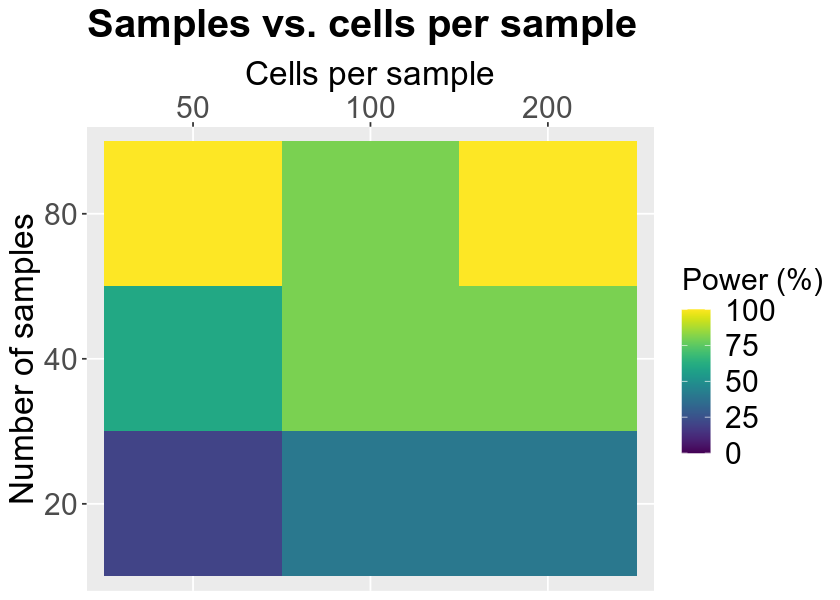

In [25]:
fig.size(5,7)
comb <- readRDS(file.path(getwd(), "samplesVsCells.rds"))
comb %>% sample_frac %>%
    ggplot(aes(x = ncells, y = nsamples, fill = Power)) +
    geom_tile() +
    scale_fill_viridis(limits = c(0,100)) +
    labs(title = 'Samples vs. cells per sample', y = 'Number of samples', x = 'Cells per sample', fill = 'Power (%)') +
    geom_hline(yintercept = 0.05, col = 'black') +
    theme(plot.title = element_text(size = 24, face = 'bold'),
          axis.title.x = element_text(size = 20), axis.title.y = element_text(size = 20),
          axis.text.x = element_text(size = 18), axis.text.y = element_text(size = 18),
          legend.title = element_text(size = 18), legend.text = element_text(size = 18)) +
    scale_x_discrete(position = "top") +
    scale_y_discrete(position = "left") 

As the results show, increasing the number of cells per sample within the same sample size did not tend to noticeably increase power in this context (RA). In contrast, increasing the number of samples in the study dramatically increased the power. 

Performing the same analysis over several datasets yielded similar results, where increasing the number of samples provided more significant power gains than increasing the number of cells per sample. More results for wider ranges and different fold changes can be found in the scPOST manuscript.

# Session information

In [28]:
sessionInfo()

R version 4.0.3 (2020-10-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux Server release 6.5 (Santiago)

Matrix products: default
BLAS/LAPACK: /PHShome/nm455/miniconda3/envs/paraR4.0.3/lib/libopenblasp-r0.3.12.so

Random number generation:
 RNG:     L'Ecuyer-CMRG 
 Normal:  Inversion 
 Sample:  Rejection 
 
locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] patchwork_1.1.1    RColorBrewer_1.1-2 ggplot2_3.3.3      dplyr_1.0.4       
[5] scpost_1.0        

loaded via a namespace (and not attached):
  [1] Seurat_4.0.0  